Instalando condacolab

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:10
🔁 Restarting kernel...


In [ ]:
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


Instalando OpenMM e OpenMMTools

In [ ]:
!mamba install -q openmm cudatoolkit=11.8 numpy>=2.0

In [ ]:
# Autor: Elvis do A. Soares
# Github: @elvissoares
from sys import stdout
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Integração Termodinâmica


In [ ]:
from openmm.app import *
from openmm import *
from openmm.unit import *

Qual molécula iremos simular?

In [ ]:
my_molecule = 'methane'

Condição termodinâmica

In [ ]:
Temperatura = 298.15 * kelvin # Temperatura em Kelvin
Pressao = 1 * bar # Pressão em bar

In [ ]:
pdb = PDBFile(f'{my_molecule}.pdb')

Escolhendo os arquivos de campo de força OPLS-AA gerados pelo LibParGen

In [ ]:
forcefield = ForceField(f'{my_molecule}.xml', 'tip3p.xml')
forcefield.setUseGeometricCombinationRule=True # OPLS-AA usa combinação geométrica

Cria a topolgia com moléculas de água ao redor (solvente)

In [ ]:
modeller = Modeller(pdb.topology, pdb.positions)

modeller.addSolvent(forcefield,model='tip3p', padding= 9.61 * angstroms)

PDBFile.writeFile(modeller.topology, modeller.positions, open(f'initial_{my_molecule}.pdb', 'w'))

In [ ]:
system = forcefield.createSystem(modeller.topology, nonbondedMethod=PME,
        nonbondedCutoff=8.5*angstroms, constraints=HBonds)

### Configuração do Sistema Alquímico

In [ ]:
!mamba install -q openmmtools

In [ ]:
# Add alchemical lambda control to methane atoms
from openmmtools import alchemy, states

solute_atoms = [atom.index for atom in modeller.topology.atoms() if atom.residue.name == "CH4"]
print("Solute atoms:", solute_atoms)

alchemical_region = alchemy.AlchemicalRegion(alchemical_atoms = solute_atoms)
solute_system = alchemy.AbsoluteAlchemicalFactory().create_alchemical_system(system, alchemical_region)

Solute atoms: [0, 1, 2, 3, 4]


In [ ]:
# Plataforma (GPU se disponível)
platform = Platform.getPlatformByName('CUDA')
# platform = Platform.getPlatformByName('CPU')

# Integrador
integrator = LangevinMiddleIntegrator(Temperatura, 1/picosecond, 2*femtoseconds)
simulation = Simulation(modeller.topology, solute_system, integrator, platform)

In [ ]:
# below corresponds to fully interacting state
simulation.context.setParameter('lambda_electrostatics', 1.0)
simulation.context.setParameter('lambda_sterics', 1.0)

In [ ]:
n_equil = 10000

simulation.context.setPositions(modeller.positions)
simulation.minimizeEnergy()

simulation.context.setVelocitiesToTemperature(Temperatura)

# Add a simple barostat for pressure control
solute_system.addForce(MonteCarloBarostat(Pressao, Temperatura))

# Equilibration
simulation.step(n_equil)

initial_positions = simulation.context.getState(getPositions=True).getPositions()

### Loop de Integração Termodinâmica

In [ ]:
n_steps = 200 # passos de MD
n_samples = 1000 # amostras da energia

lambda_ele_grid = np.linspace(1.0, 0.0, 11)
U_mean_ele = np.zeros_like(lambda_ele_grid)
U_std_ele = np.zeros_like(lambda_ele_grid)

for i, l in enumerate(lambda_ele_grid):
    print('lambda:',l)

    simulation.context.setPositions(initial_positions)
    #define novo lambda a ser simulado
    simulation.context.setParameter('lambda_electrostatics', l)

    #equilibração para novo lambda
    simulation.step(n_equil)

    #produção para novo lambda
    U_lambda = []
    for iteration in range(n_samples):
        simulation.step(n_steps)
        e = simulation.context.getState(energy=True).getPotentialEnergy().value_in_unit(kilojoules_per_mole)
        U_lambda.append(e)
        # print(iteration,deriv)

    U_mean_ele[i] = np.mean(np.array(U_lambda))
    U_std_ele[i] = np.std(np.array(U_lambda))
    print(f"U_λ^ele: {U_mean_ele[i]:.4f} +- {U_std_ele[i]:.4f}")

lambda: 1.0
U_λ^ele: -8360.1189 +- 79.9594
lambda: 0.9
U_λ^ele: -8362.1219 +- 90.7762
lambda: 0.8
U_λ^ele: -8364.7155 +- 92.5402
lambda: 0.7
U_λ^ele: -8355.3348 +- 85.2959
lambda: 0.6
U_λ^ele: -8361.3195 +- 92.3568
lambda: 0.5
U_λ^ele: -8357.0552 +- 95.8119
lambda: 0.3999999999999999
U_λ^ele: -8358.5097 +- 90.5477
lambda: 0.29999999999999993
U_λ^ele: -8356.5840 +- 90.9823
lambda: 0.19999999999999996
U_λ^ele: -8363.8918 +- 87.2422
lambda: 0.09999999999999998
U_λ^ele: -8373.8107 +- 89.2018
lambda: 0.0
U_λ^ele: -8354.4144 +- 92.6699


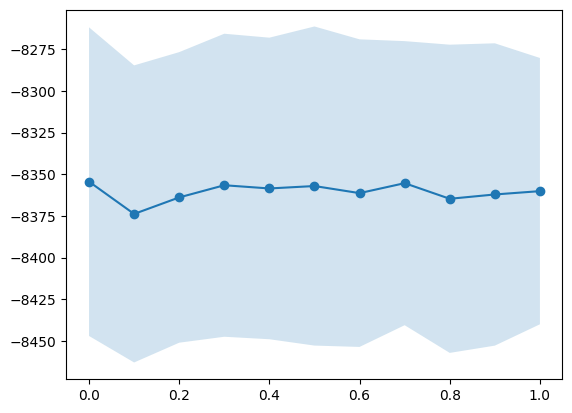

In [ ]:
plt.plot(lambda_ele_grid, U_mean_ele, marker='o', label='U_λ^ele')
plt.fill_between(lambda_ele_grid, U_mean_ele - U_std_ele, U_mean_ele + U_std_ele, alpha=0.2)

In [ ]:
lambda_steric_grid = np.linspace(1.0, 0.0, 11)
U_mean_steric = np.zeros_like(lambda_steric_grid)
U_std_steric = np.zeros_like(lambda_steric_grid)

for i, l in enumerate(lambda_steric_grid):
    print('lambda:',l)

    simulation.context.setPositions(initial_positions)
    simulation.context.setParameter('lambda_sterics', l)

    simulation.step(n_equil)

    # Collect U_λ data
    U_lambda = []
    for iteration in range(n_samples):
        simulation.step(n_steps)
        e = simulation.context.getState(energy=True).getPotentialEnergy().value_in_unit(kilojoules_per_mole)
        U_lambda.append(e)

    U_mean_steric[i] = np.mean(np.array(U_lambda))
    U_std_steric[i] = np.std(np.array(U_lambda))
    print(f"U_λ^ste: {U_mean_steric[i]:.4f} +- {U_std_steric[i]:.4f}")

lambda: 1.0
U_λ^ste: -8364.5088 +- 85.1367
lambda: 0.9
U_λ^ste: -8366.7001 +- 87.4364
lambda: 0.8
U_λ^ste: -8367.7270 +- 87.9281
lambda: 0.7
U_λ^ste: -8356.2383 +- 85.6348
lambda: 0.6
U_λ^ste: -8371.4760 +- 92.7509
lambda: 0.5
U_λ^ste: -8355.3171 +- 87.6500
lambda: 0.3999999999999999
U_λ^ste: -8356.4133 +- 82.6853
lambda: 0.29999999999999993
U_λ^ste: -8363.3507 +- 88.5844
lambda: 0.19999999999999996
U_λ^ste: -8348.6476 +- 89.1047
lambda: 0.09999999999999998
U_λ^ste: -8347.8696 +- 86.5056
lambda: 0.0
U_λ^ste: -8345.9474 +- 87.5331


Text(0, 0.5, 'U_λ (kJ/mol)')

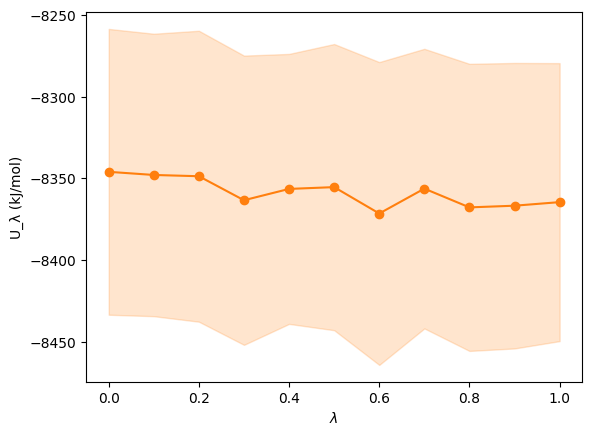

In [ ]:
plt.plot(lambda_steric_grid, U_mean_steric, marker='o', color='C1', label='U_λ^ste')
plt.fill_between(lambda_steric_grid, U_mean_steric - U_std_steric, U_mean_steric + U_std_steric, color='C1', alpha=0.2)
plt.xlabel('$\lambda$')
plt.ylabel('U_λ (kJ/mol)')

Salvando dados em arquivo `.txt`

In [ ]:
# np.savetxt('lambda_electrostatic.txt', [lambda_ele_grid, U_mean_ele, U_std_ele])
# np.savetxt('lambda_steric.txt', [lambda_steric_grid, U_mean_steric, U_std_steric])

Salvando dados em arquivo `.xls`

In [ ]:
df = pd.DataFrame()
df['lambda_ele'] = lambda_ele_grid
df['U_ele'] = U_mean_ele
df['err U_ele'] = U_std_ele

df['lambda_steric'] = lambda_steric_grid
df['U_steric'] = U_mean_steric
df['err U_steric'] = U_std_steric

df.to_excel('integracao_termodinamica.xlsx',sheet_name='sim1', index=False)

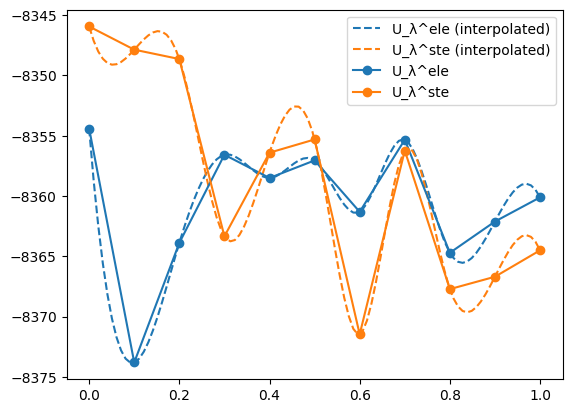

In [ ]:
# Interpolate U_λ with a smooth function and calculate the derivative
from scipy.interpolate import CubicSpline
interp_func_ele = CubicSpline(lambda_ele_grid[::-1], U_mean_ele[::-1])
interp_func_steric = CubicSpline(lambda_steric_grid[::-1], U_mean_steric[::-1])
lambda_grid = np.linspace(0.0, 1.0, 100)
U_ele = interp_func_ele(lambda_grid)
U_steric = interp_func_steric(lambda_grid)

plt.plot(lambda_grid, U_ele, label='U_λ^ele (interpolated)', linestyle='--')
plt.plot(lambda_grid, U_steric, label='U_λ^ste (interpolated)', linestyle='--')
plt.plot(lambda_ele_grid, U_mean_ele, marker='o',color='C0', label='U_λ^ele')
plt.plot(lambda_steric_grid, U_mean_steric, marker='o', color='C1', label='U_λ^ste')
plt.legend()

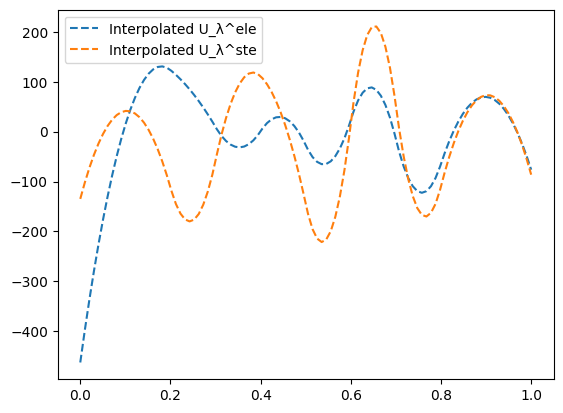

In [ ]:
# Calculate the derivatives of the interpolated functions
dU_ele_dlambda = interp_func_ele.derivative()(lambda_grid)
dU_steric_dlambda = interp_func_steric.derivative()(lambda_grid)

# Plot the interpolated U_λ
plt.plot(lambda_grid, dU_ele_dlambda, label='Interpolated U_λ^ele', linestyle='--')
plt.plot(lambda_grid, dU_steric_dlambda, label='Interpolated U_λ^ste', linestyle='--')
plt.legend()

In [ ]:
deltaG_ele = np.trapezoid(dU_ele_dlambda, lambda_grid)

print(f"ΔG_ele = {deltaG_ele:.3f} kJ/mol")

ΔG_ele = -5.786 kJ/mol


In [ ]:
deltaG_steric = np.trapezoid(dU_steric_dlambda, lambda_grid)

print(f"ΔG_steric = {deltaG_steric:.3f} kJ/mol")

ΔG_steric = -18.619 kJ/mol


In [ ]:
1.6e-19*(6.022e23) # conversão de Joules para kJ/mol

96352.0

In [ ]:
deltaG = deltaG_ele + deltaG_steric
print(f"ΔG_total = {deltaG:.3f} kJ/mol")
# Convert to eV
deltaG_eV = deltaG / 96.352
print(f"ΔG_total = {deltaG_eV:.3f} eV")

ΔG_total = -24.404 kJ/mol
ΔG_total = -0.253 eV


In [ ]:
3.4/40

**<span style="color:#A03;font-size:14pt">
&#x270B; HANDS-ON! &#x1F528;
</span>**

> Faça uma estimativa do custo computacional (tempo de simulação) no seu _hardware_ atual para simulações longas da ordem de 1ns.
>